<a href="https://colab.research.google.com/github/syedsauda/CE888/blob/master/Assignment2/Assignment2_dataset2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Download and install scikit plot

In [0]:
pip install scikit-plot

#Importing Libraries

In [0]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import scikitplot as skplt
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler 
from sklearn.model_selection import cross_val_score

from zipfile import ZipFile

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


#Functions

##Split and classify dataset

In [0]:
def split_and_classify(df, feature):
  #Removing column to classify (TARGET)
  X = df.drop(columns=[feature]) 
  y = df[feature]

  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, shuffle=True) #Randomising nad splitting before classification
  
  rfc = RandomForestClassifier()
  rfc.fit(X_train, y_train)
  y_test_score = rfc.predict_proba(X_test)
  skplt.metrics.plot_roc(y_test, y_test_score)
  plt.show()
  print('AUC score: ', round(roc_auc_score(y_true=y_test, y_score=y_test_score[:,1]), 4))
  return X,y;

##Classify train and test datasets

In [0]:
def classify_rfc(train_df, test_df, feature):

  X_train = train_df.drop(columns=[feature])
  y_train = train_df[feature]

  X_test = test_df.drop(columns=[feature])
  y_test = test_df[feature]
  
  rfc = RandomForestClassifier()
  rfc.fit(X_train, y_train)
  y_test_score = rfc.predict_proba(X_test)
  skplt.metrics.plot_roc(y_test, y_test_score)
  plt.show()
  print('AUC score: ', round(roc_auc_score(y_true=y_test, y_score=y_test_score[:,1]), 4))

##Plot Histogram of variable

In [0]:
def histo(df_test, df_train, feature):
  print("Histogram of dataset on '",feature,"'")
  histo = sns.distplot(df_test[[feature]].values.T[0], color="blue", kde=False, label="Testing data")
  histo = sns.distplot(df_train[[feature]].values.T[0], color="red", kde=False, label="Training data")
  legend = histo.legend()

#Load dataset into pandas dataframe

In [0]:
dataset_link = "https://raw.githubusercontent.com/syedsauda/CE888/master/Assignment2/train.csv"
orig_df_train = pd.read_csv(dataset_link, header=0, sep=',', quotechar='"')

print(orig_df_train)

     age  sex  cp  trestbps  chol  fbs  ...  exang  oldpeak  slope  ca  thal  target
0     63    1   3       145   233    1  ...      0      2.3      0   0     1       1
1     37    1   2       130   250    0  ...      0      3.5      0   0     2       1
2     41    0   1       130   204    0  ...      0      1.4      2   0     2       1
3     56    1   1       120   236    0  ...      0      0.8      2   0     2       1
4     57    0   0       120   354    0  ...      1      0.6      2   0     2       1
..   ...  ...  ..       ...   ...  ...  ...    ...      ...    ...  ..   ...     ...
298   57    0   0       140   241    0  ...      1      0.2      1   0     3       0
299   45    1   3       110   264    0  ...      0      1.2      1   0     3       0
300   68    1   0       144   193    1  ...      0      3.4      1   2     3       0
301   57    1   0       130   131    0  ...      1      1.2      1   1     3       0
302   57    0   1       130   236    0  ...      0      0.0      

#Creating test and training datasets with covariate shift

And removing target column 

In [0]:
target_var = "target"
age = 60

df_train = orig_df_train.where(orig_df_train["age"]<=age).dropna().drop(columns=[target_var])
df_test = orig_df_train.where(orig_df_train["age"]>age).dropna().drop(columns=[target_var])

#Detecting Covariate shift in data

Adding is_test column for later calssification

In [0]:
df_train['is_test'] = 0
df_test['is_test'] = 1

combine testing and training datasets and classify for is_test

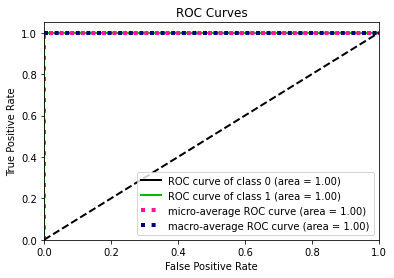

AUC score:  1.0


In [0]:
df = pd.concat([df_train, df_test], axis = 0)
X,y = split_and_classify(df,"is_test")

Since the AUC Score is higer than 0.8 we know that there is covarite shift in the datasets as the classifier is able to classify whether or not the given data is form the training or testing dataset.

---

---

Finding features causing covariate shift

In [0]:
drop_list = []
model = RandomForestClassifier(n_estimators = 50, max_depth = 5,min_samples_leaf = 5)
for i in X.columns:
    score = cross_val_score(model,pd.DataFrame(X[i]),y,cv=2,scoring='roc_auc')
    if (np.mean(score) > 0.8):
        drop_list.append(i)
        print(i,np.mean(score))

age 1.0


Histogram of variable(s) with covariate shift

Histogram of dataset on ' age '


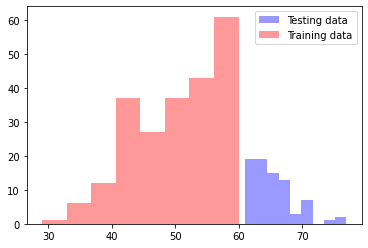

In [0]:
histo(df_test, df_train,drop_list[0])

#Fixing Covariate shift in datasets

Removing features that cause shift and classify 'is_test'

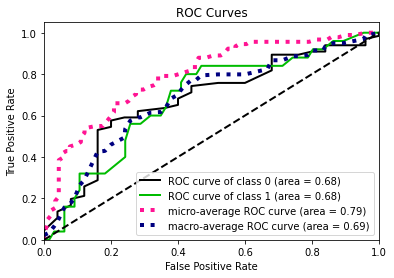

AUC score:  0.68


In [0]:
df.drop(columns=drop_list,inplace=True)
unused,unused2 = split_and_classify(df,"is_test")

Since the AUC Score is lower than 0.8 it means that we are unable to clssify whether the given data is from the testing or training dataset.
Hence, this indicates that the apparent covariate shift in data has been removed.

---

#Testing performance of classifier under co-variate shift in data 

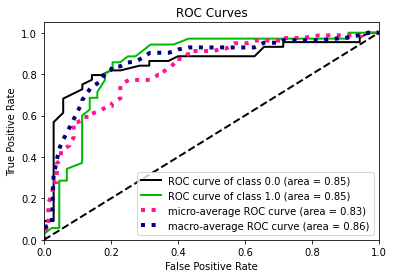

AUC score:  0.8532


In [0]:
df_train = orig_df_train.where(orig_df_train["age"]<=age).dropna()
df_test = orig_df_train.where(orig_df_train["age"]>age).dropna()
classify_rfc(df_train,df_test,"target")

#Testing performance of classifier with co-variate shift removed

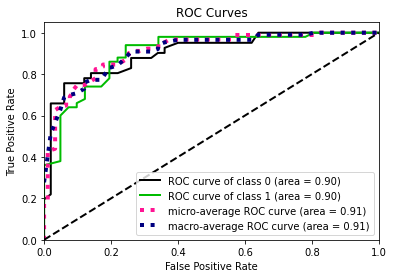

AUC score:  0.9034


In [0]:
unused,unused2 = split_and_classify(orig_df_train.drop(columns=["age"]),"target")

#Testing performance of classifier with no covariate shift and keeping all features

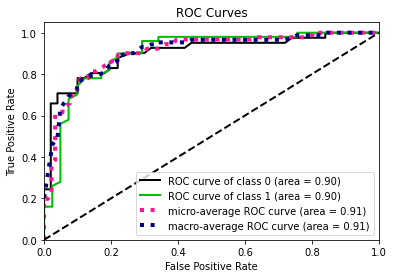

AUC score:  0.9017


In [0]:
unused,unused2 = split_and_classify(orig_df_train,"target")